In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
data1 = pd.read_csv("/content/Walmart DataSet.csv")

In [7]:
data1['Date'] = pd.to_datetime(data1['Date'], dayfirst=True)

In [8]:
data1.set_index('Date', inplace=True)

In [9]:
a = int(input("Enter store:")) # store id
store = data1[data1['Store'] == a]

Enter store:22


In [10]:
sales = store.groupby(store.index)['Weekly_Sales'].sum().to_frame()

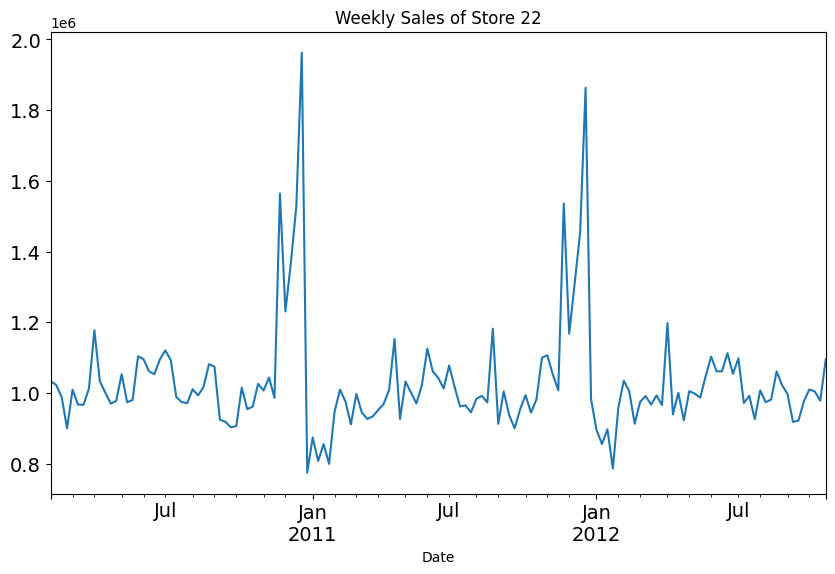

In [11]:
# Plot
sales['Weekly_Sales'].plot(
    figsize=(10,6),
    title=f'Weekly Sales of Store {a}',
    fontsize=14
)

plt.show()

<Figure size 640x480 with 0 Axes>

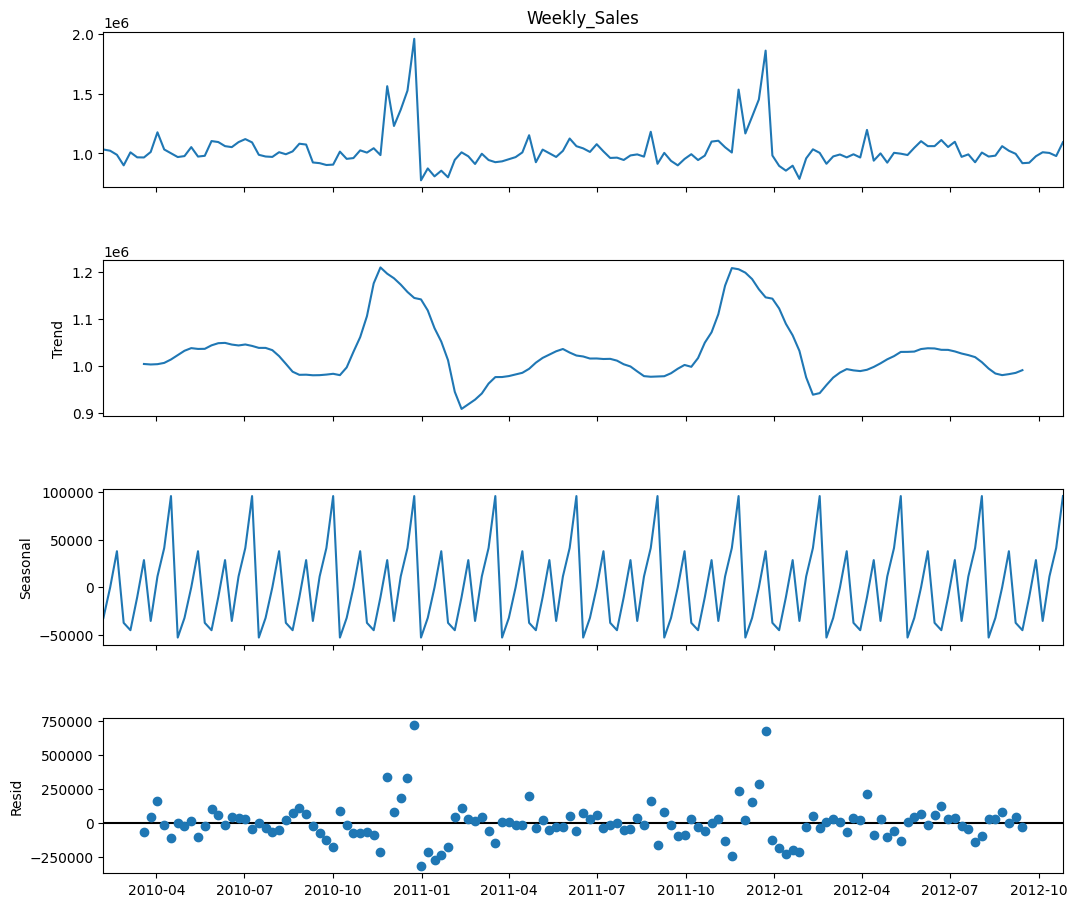

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales.Weekly_Sales, period=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

In [13]:
#lets compare the 2012 data of two stores
# Lets take store 5 data for analysis
store5 = data1[data1.Store == 5]
# there are about 45 different stores in this dataset.

sales5 = pd.DataFrame(store5.Weekly_Sales.groupby(store5.index).sum())
sales5.dtypes
# Grouped weekly sales by store 6

#remove date from index to change its dtype because it clearly isnt acceptable.
sales5.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales5['Date'] = pd.to_datetime(sales5['Date'])
# resetting date back to the index
sales5.set_index('Date',inplace = True)

In [14]:
y1=sales.Weekly_Sales
y2=sales5.Weekly_Sales

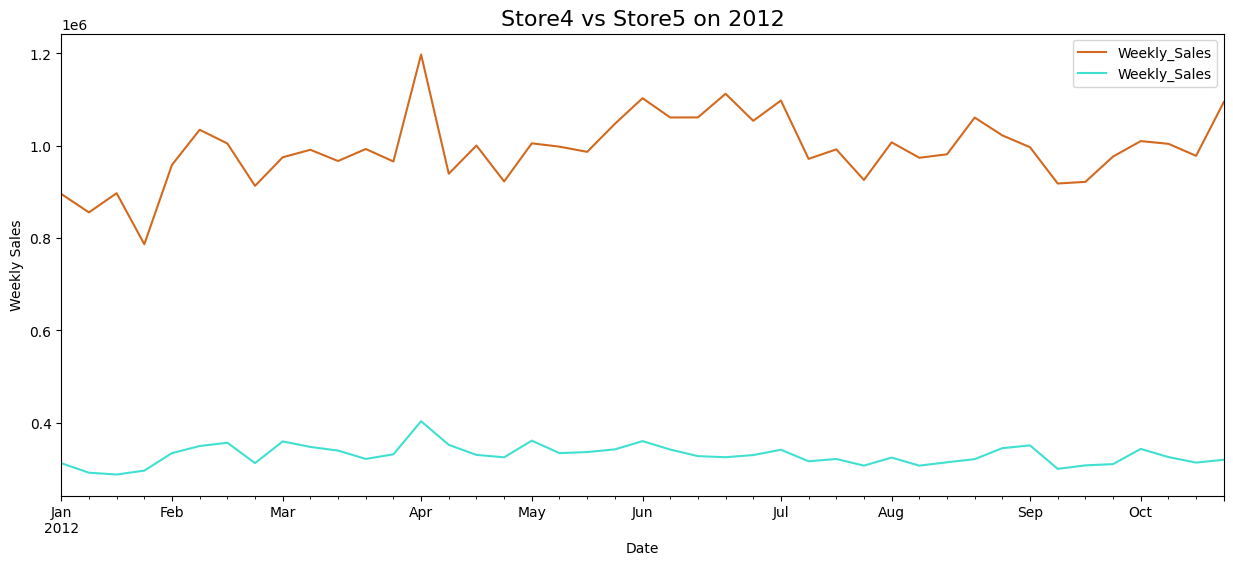

In [15]:
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store5 on 2012', fontsize = '16')
plt.show()

In [16]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)
import itertools
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [17]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(4, 4, 3),
                                seasonal_order=(1, 1, 0, 52),   #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8794      0.629     -2.989      0.003      -3.112      -0.647
ar.L2         -1.5963      0.841     -1.899      0.058      -3.244       0.051
ar.L3         -0.8243      0.718     -1.149      0.251      -2.231       0.582
ar.L4         -0.1689      0.350     -0.483      0.629      -0.855       0.517
ma.L1         -1.1957      0.635     -1.882      0.060      -2.441       0.050
ma.L2         -0.5342      1.136     -0.470      0.638      -2.760       1.692
ma.L3          0.7379      0.558      1.322      0.186      -0.356       1.832
ar.S.L52      -0.2092      0.089     -2.356      0.018      -0.383      -0.035
sigma2      1.696e+10   7.93e-11   2.14e+20      0.000     1.7e+10     1.7e+10


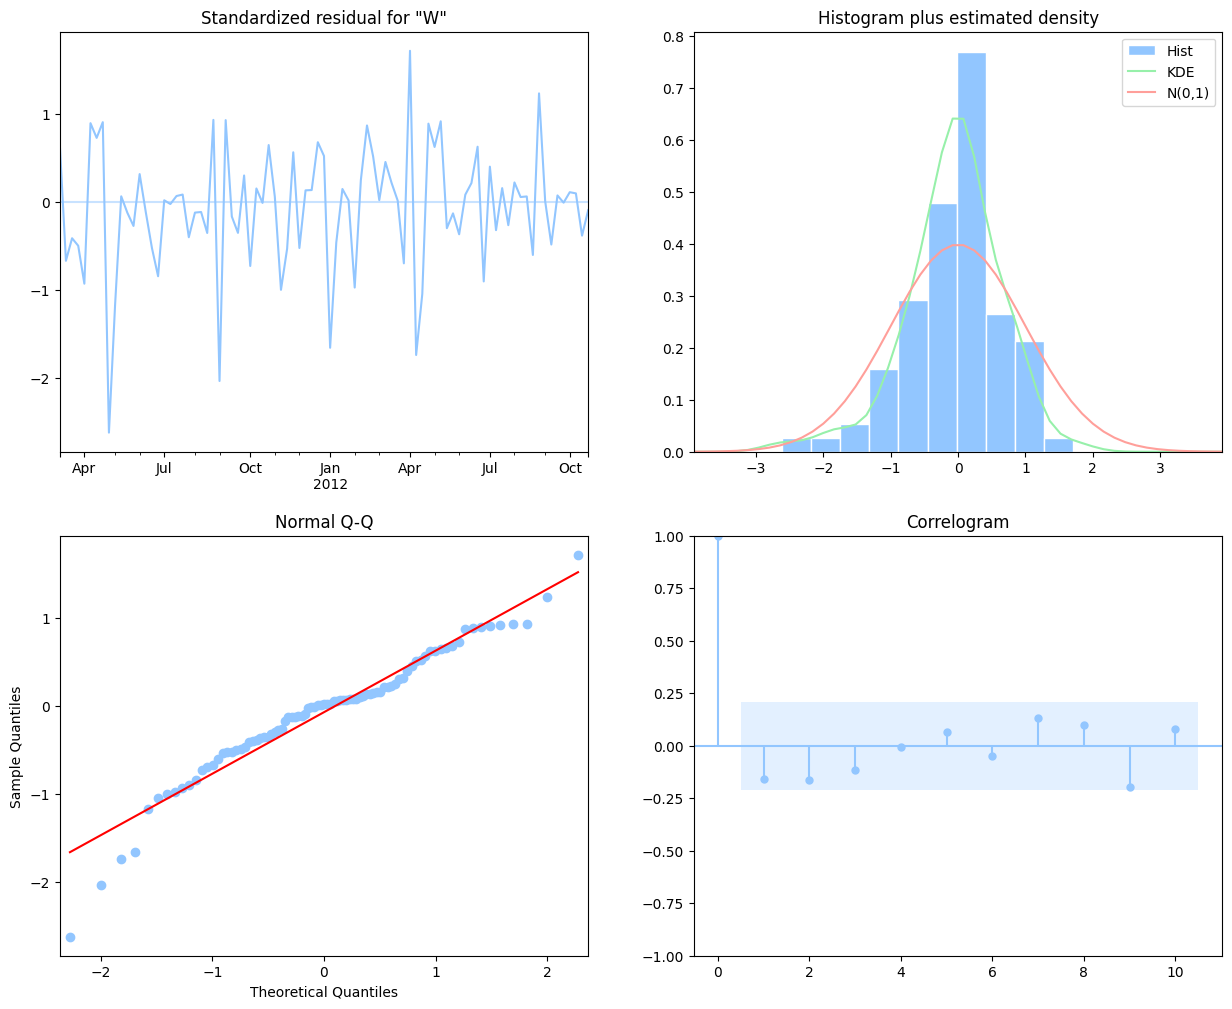

In [19]:
plt.style.use('seaborn-v0_8-pastel')
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()

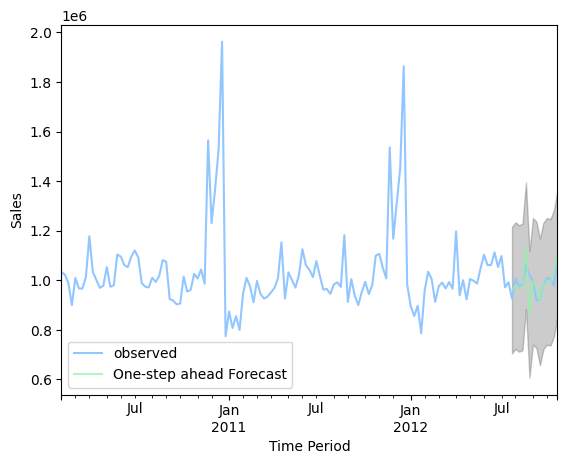

In [21]:
ax = y1['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [22]:
y_forecasted = pred.predicted_mean
y_truth = y1['2012-7-27':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2927780462.2


In [23]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


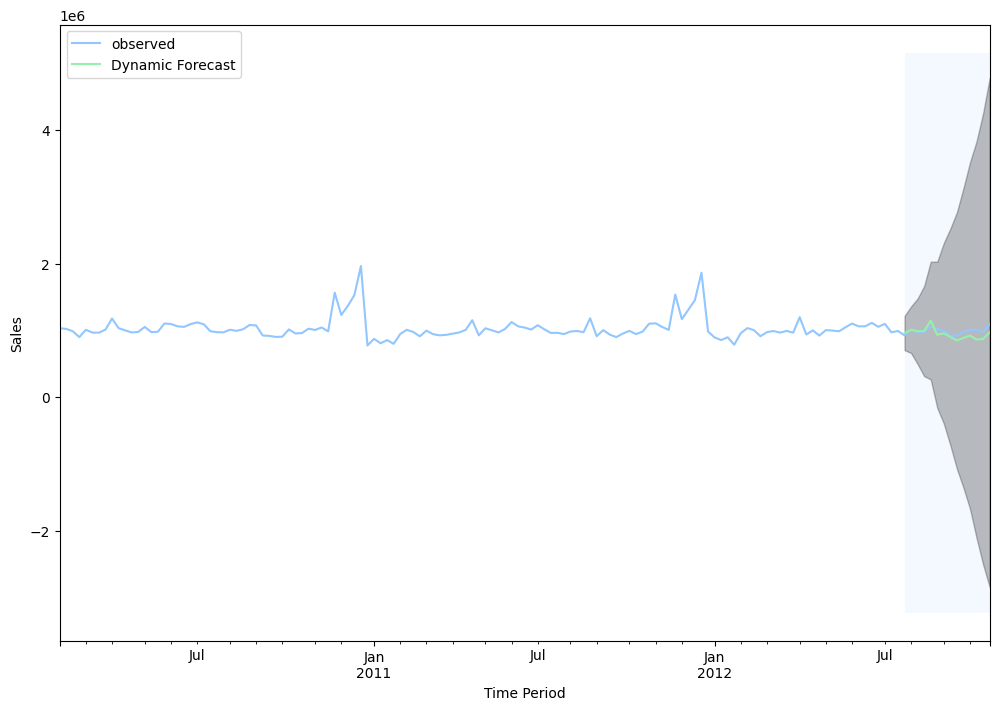

In [24]:
ax = y1['2010':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), y1.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()


In [25]:
import numpy as np
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
print(y_forecasted)

2012-07-27    9.601861e+05
2012-08-03    1.010527e+06
2012-08-10    9.867221e+05
2012-08-17    9.905082e+05
2012-08-24    1.146860e+06
2012-08-31    9.351471e+05
2012-09-07    9.573047e+05
2012-09-14    9.023570e+05
2012-09-21    8.490812e+05
2012-09-28    8.877478e+05
2012-10-05    9.225486e+05
2012-10-12    8.625700e+05
2012-10-19    8.732212e+05
2012-10-26    9.684878e+05
Freq: W-FRI, Name: predicted_mean, dtype: float64


In [26]:
y_truth = y1['2012-7-27':]

print(y_truth)

Date
2012-07-27     925731.21
2012-08-03    1007257.83
2012-08-10     973812.79
2012-08-17     981273.26
2012-08-24    1060906.75
2012-08-31    1022270.86
2012-09-07     996628.80
2012-09-14     918049.28
2012-09-21     921612.53
2012-09-28     976479.51
2012-10-05    1009887.36
2012-10-12    1004039.84
2012-10-19     978027.95
2012-10-26    1094422.69
Name: Weekly_Sales, dtype: float64


In [27]:
# Compute the Root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 78303.83


In [28]:
Residual= y_forecasted - y_truth
print("Residual for Store1",np.abs(Residual).sum())

Residual for Store1 908775.3551510391


In [29]:
# Get forecast 12 weeks ahead in future
pred_uc = results.get_forecast(steps=12)

print(pred_uc)

In [30]:
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

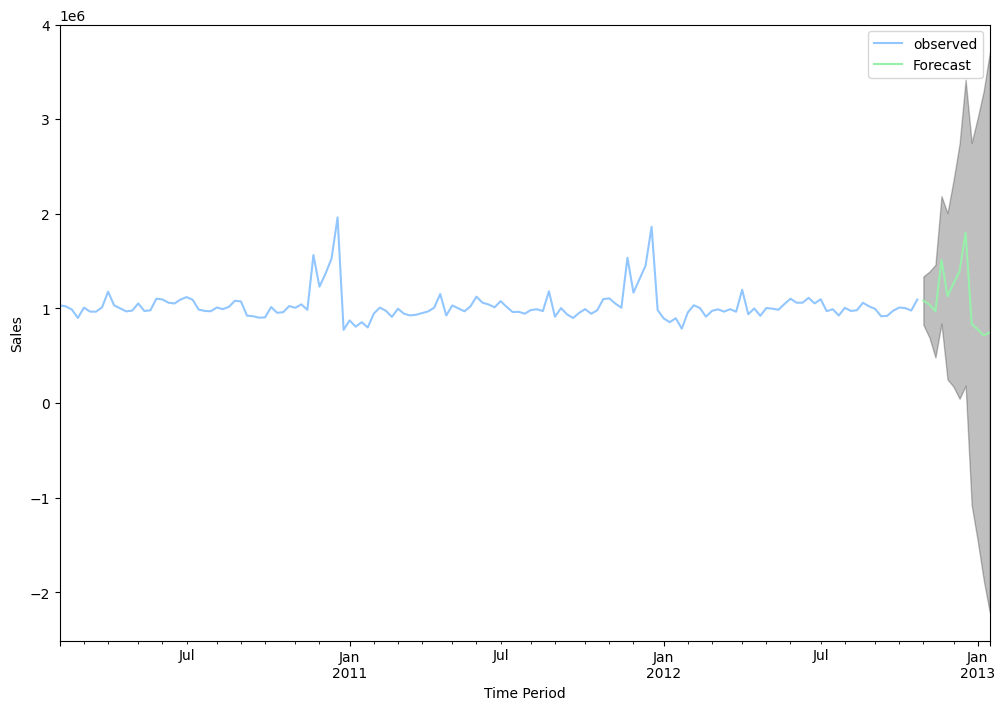

In [31]:

ax = y1.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()